# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [90]:
# Load the libraries as required.
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


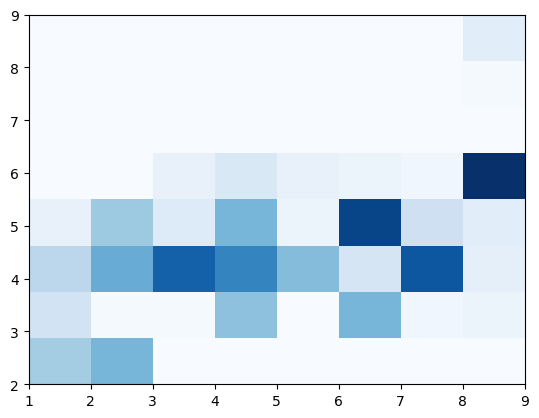

In [25]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

#visualize x,y distribution of data
xco = fires_dt['coord_x']
yco = fires_dt['coord_y']
plt.hist2d(
    x=xco,
    y=yco,
    bins=8,
    cmap='Blues',
)
plt.show()

>**observations:** We can observe the x,y frequencies of the training data in the plot above

(array([  8.,  24.,  28.,  23.,  79., 106.,  87.,  40.,  31.,  27.,  23.,
         12.,  19.,   0.,   6.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.    ,  1.4025,  2.805 ,  4.2075,  5.61  ,  7.0125,  8.415 ,
         9.8175, 11.22  , 12.6225, 14.025 , 15.4275, 16.83  , 18.2325,
        19.635 , 21.0375, 22.44  , 23.8425, 25.245 , 26.6475, 28.05  ,
        29.4525, 30.855 , 32.2575, 33.66  , 35.0625, 36.465 , 37.8675,
        39.27  , 40.6725, 42.075 , 43.4775, 44.88  , 46.2825, 47.685 ,
        49.0875, 50.49  , 51.8925, 53.295 , 54.6975, 56.1   ]),
 [<matplotlib.patches.Polygon at 0x163388820>])

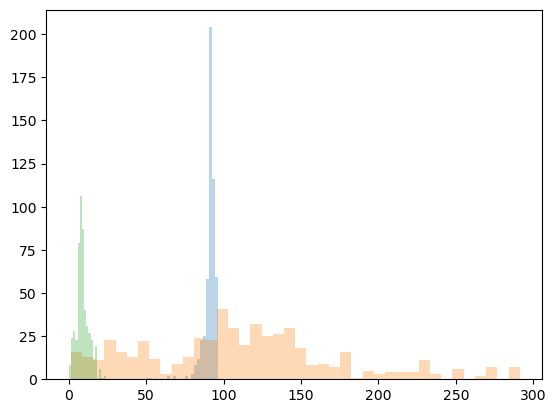

In [26]:
#visualize distributions of roughly normally distributed parameters overlayed
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
x1 = fires_dt['ffmc']
x2 = fires_dt['dmc']
x3 = fires_dt['isi']

plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)
plt.hist(x3, **kwargs)


>**observations:** In this overlay of histograms of feature distributions, we can recognize that each is somewhat normal and can be effectively transformed with RobustScaler

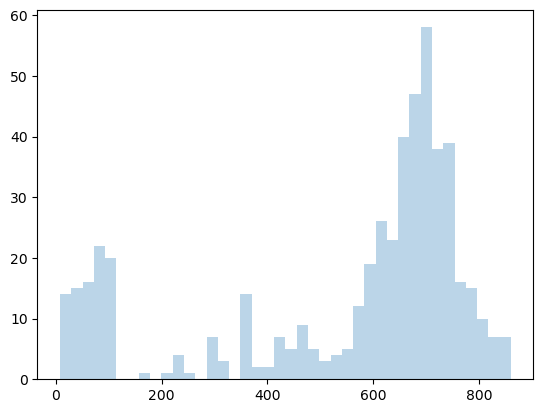

In [27]:
x4 = fires_dt['dc']
plt.hist(x4, **kwargs);
#candidate for non-linear distribution


>**observations:** In this histogram of feature distribution, we can recognize that the feature is a candidate for non-linear transformation since most_frequent value differs from mean significantly

(array([ 1.,  0., 13.,  0., 14.,  0., 31.,  0., 53.,  0., 44.,  0., 53.,
         0., 40.,  0., 51.,  0., 41.,  0., 48.,  0., 41., 24.,  0.,  0.,
        19.,  0.,  8.,  0.,  4., 14.,  0.,  5.,  0.,  0.,  8.,  1.,  0.,
         4.]),
 array([0.4  , 0.625, 0.85 , 1.075, 1.3  , 1.525, 1.75 , 1.975, 2.2  ,
        2.425, 2.65 , 2.875, 3.1  , 3.325, 3.55 , 3.775, 4.   , 4.225,
        4.45 , 4.675, 4.9  , 5.125, 5.35 , 5.575, 5.8  , 6.025, 6.25 ,
        6.475, 6.7  , 6.925, 7.15 , 7.375, 7.6  , 7.825, 8.05 , 8.275,
        8.5  , 8.725, 8.95 , 9.175, 9.4  ]),
 [<matplotlib.patches.Polygon at 0x16347d1c0>])

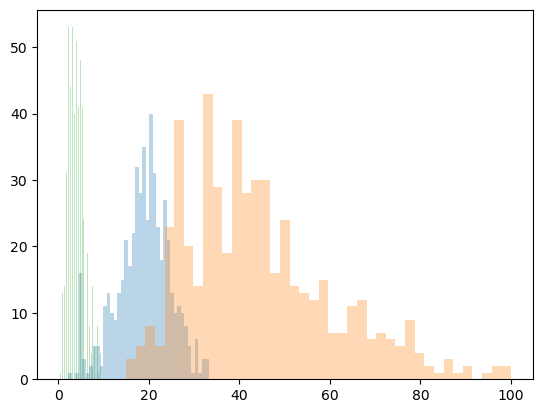

In [28]:
#visualize distributions of various parameters overlayed
x1 = fires_dt['temp']
x2 = fires_dt['rh']
x3 = fires_dt['wind']
x4 = fires_dt['rain']

plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)
plt.hist(x3, **kwargs)
#plt.hist(x4, **kwargs);
#rain was very much not normal

>**observations:** In this overlay of feature distribution histograms, we can recognize that each is somewhat normal and can be effectively transformed with RobustScaler

In [29]:
fires_dt['rain'].describe()

count    517.000000
mean       0.021663
std        0.295959
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: rain, dtype: float64

(array([511.,   1.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.  , 0.32, 0.64, 0.96, 1.28, 1.6 , 1.92, 2.24, 2.56, 2.88, 3.2 ,
        3.52, 3.84, 4.16, 4.48, 4.8 , 5.12, 5.44, 5.76, 6.08, 6.4 ]),
 <BarContainer object of 20 artists>)

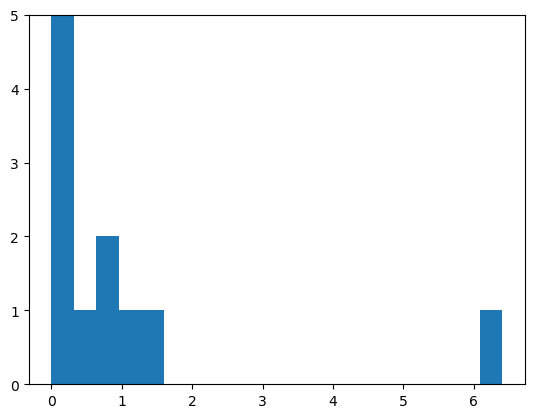

In [30]:
#visualize rain data
plt.ylim(0, 5)
plt.hist(fires_dt['rain'],bins=20)

# candidate for non-linear transform

>**observations:** We can see that the rain feature is highly imbalanced, 1/100 rate, hence it is a candidate for non-linear transformation

(array([266.,  20.,  33., ...,   0.,   0.,   1.]),
 array([0.00000000e+00, 7.27226667e-01, 1.45445333e+00, ...,
        1.08938555e+03, 1.09011277e+03, 1.09084000e+03]),
 <BarContainer object of 1500 artists>)

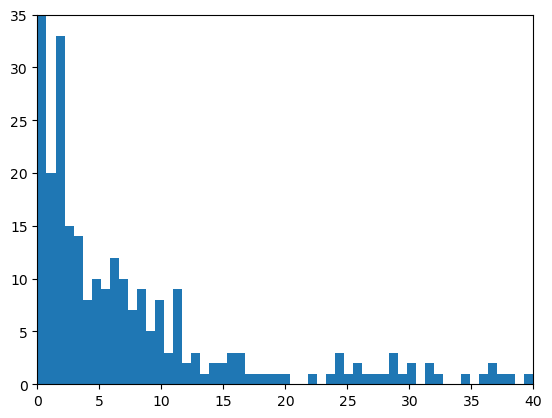

In [31]:
plt.ylim(0, 35)
plt.xlim(0, 40)
plt.hist(fires_dt['area'],bins=1500)

(array([446.,  27.,  16.,   7.,   6.,   2.,   2.,   2.,   0.,   0.,   1.,
          0.,   2.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.        ,   14.54453333,   29.08906667,   43.6336    ,
          58.17813333,   72.72266667,   87.2672    ,  101.81173333,
         116.35626667,  130.9008    ,  145.44533333,  159.98986667,
         174.5344    ,  189.07893333,  203.62346667,  218.168     ,
         232.71253333,  247.25706667,  261.8016    ,  276.34613333,
         290.89066667,  305.4352    ,  319.97973333,  334.52426667,
         349.0688    ,  363.61333333,  378.15786667,  392.7024    ,
         407.246

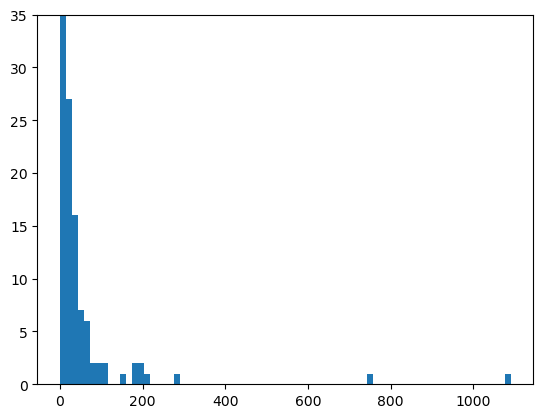

In [32]:
plt.ylim(0, 35)
plt.hist(fires_dt['area'],bins=75)

>**observations:** We can see that the target variable is somewhat log-normally distributed, the model might benefit from transforming the target variable although that approach will not be investigated in this assignment

# Get X and Y

Create the features data frame and target data.

In [33]:
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [34]:
fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [35]:
#define numeric columns based on fires_dt.info()
ft_num = ['coord_x',
         'coord_y',
         'ffmc',
         'dmc',
         'dc',
         'isi',
         'temp',
         'rh',
         'wind',
         'rain',
         ]

#define categoric columns based on fires_dt.info()
ft_cat = ['month',
         'day',
         ]

preproc1 = ColumnTransformer([
    ('cat_transforms',OneHotEncoder(handle_unknown='ignore'),ft_cat),
    ('num_transforms',RobustScaler(),ft_num),
    ],remainder='passthrough')

preproc1

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day']),
                                ('num_transforms', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain'])])

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [36]:
#list(fires_dt.drop(columns=['area']).columns)
fires_dt['month'].value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In [37]:
ft_scaled = ['coord_x',
         'coord_y',
         'ffmc',
         'dmc',
         'isi',
         'temp',
         'rh',
         'wind',
         ]

ft_non_linear = ['dc',
                 'rain',
                 ]

ft_cat = ['month',
         'day',
         ]

preproc2 = ColumnTransformer([
    ('cat_transforms',OneHotEncoder(handle_unknown='ignore'),ft_cat),
    ('num_scaled_ft',RobustScaler(),ft_scaled),
    ('num_nonlin_ft',QuantileTransformer(n_quantiles=25),ft_non_linear),

    ],remainder='passthrough')

#Verify the sklearn objects by calling them
preproc2

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day']),
                                ('num_scaled_ft', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'isi',
                                  'temp', 'rh', 'wind']),
                                ('num_nonlin_ft',
                                 QuantileTransformer(n_quantiles=25),
                                 ['dc', 'rain'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [38]:
#define the experiment parameters that inform pipelines ABCD
baseline_model = Lasso()
advanced_model = GradientBoostingRegressor()

In [39]:
# Pipeline A = preproc1 + baseline model
pipe_a = Pipeline([
    ('preprocessing',preproc1),
    ('regressor',baseline_model)
    ])
pipe_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('num_transforms',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain'])])),
                ('regressor', Lasso())])

In [40]:
# Pipeline B = preproc2 + baseline model
pipe_b = Pipeline([
    ('preprocessing',preproc2),
    ('regressor',baseline_model),
])
pipe_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('num_scaled_ft',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'isi', 'temp', 'rh',
                                                   'wind']),
                                                 ('num_nonlin_ft',
                                                  QuantileTransformer(n_quantiles=25),
                                                  ['dc', 'rain'])])),
                ('regressor', Lasso())])

In [41]:
# Pipeline C = preproc1 + advanced model
pipe_c = Pipeline([
    ('preprocessing',preproc1),
    ('regressor',advanced_model),
])
pipe_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('num_transforms',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain'])])),
                ('regressor', GradientBoostingRegressor())])

In [42]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline([
    ('preprocessing',preproc2),
    ('regressor',advanced_model),
])
pipe_d

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('num_scaled_ft',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'isi', 'temp', 'rh',
                                                   'wind']),
                                                 ('num_nonlin_ft',
                                                  QuantileTransformer(n_quantiles=25),
                                                  ['dc', 'rain'])])),
                ('regressor', GradientBoostingRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [43]:
#pipe_a.get_params()
pipe_d.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('cat_transforms',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['month', 'day']),
                                   ('num_scaled_ft', RobustScaler(),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'isi',
                                     'temp', 'rh', 'wind']),
                                   ('num_nonlin_ft',
                                    QuantileTransformer(n_quantiles=25),
                                    ['dc', 'rain'])])),
  ('regressor', GradientBoostingRegressor())],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('cat_transforms',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['month', 'day']),
                        

In [49]:
#configure callable parameters for the grid search
performance_metrics = [
    'neg_mean_absolute_error', 
    'neg_mean_square_error'
    'neg_mean_absolute_percentage_error'
    'explained_variance'
    'r2'
]
#folds = 5

baseline_param_grid = {
    'regressor__alpha': [0.2, 0.5, 1.0, 2.0,5.0,10.0],
    'regressor__tol': [1e-4,5e-5,1e-5],
    'regressor__max_iter': [1000,5000,10000],
    }
advanced_param_grid = {
    'regressor__n_estimators': [100, 200,500],
    'regressor__max_depth': [2,3,4,5,7,10],
    }

In [86]:
# Grid search and results with
grid_cv_a = GridSearchCV(
    estimator=pipe_a, 
    param_grid=baseline_param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=5,
    refit = 'neg_mean_absolute_error'
    )
grid_cv_a.fit(X_train, Y_train)
res_a = pd.DataFrame(grid_cv_a.cv_results_).set_index("rank_test_score").sort_values(by='rank_test_score')
res_a[['mean_test_score','std_test_score','params']].iloc[0:3]

,mean_test_score,std_test_score,params
rank_test_score,,,
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."


In [87]:
# Grid search and results with pipe_b
grid_cv_b = GridSearchCV(
    estimator=pipe_b, 
    param_grid=baseline_param_grid, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5,
    refit = "neg_mean_absolute_error")
grid_cv_b.fit(X_train, Y_train)
res_b = pd.DataFrame(grid_cv_b.cv_results_).set_index("rank_test_score").sort_values(by='rank_test_score')
res_b[['mean_test_score','std_test_score','params']].iloc[0:3]

,mean_test_score,std_test_score,params
rank_test_score,,,
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."
1,-15.728933,3.331395,"{'regressor__alpha': 2.0, 'regressor__max_iter..."


In [88]:
# Grid search and results with pipe_c
grid_cv_c = GridSearchCV(
    estimator=pipe_c, 
    param_grid=advanced_param_grid, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5,
    refit = 'neg_mean_absolute_error')
grid_cv_c.fit(X_train, Y_train)
res_c = pd.DataFrame(grid_cv_c.cv_results_).set_index("rank_test_score").sort_values(by='rank_test_score')
res_c[['mean_test_score','std_test_score','params']].iloc[0:3]

,mean_test_score,std_test_score,params
rank_test_score,,,
1,-20.635971,5.475724,"{'regressor__max_depth': 2, 'regressor__n_esti..."
2,-21.579500,5.051568,"{'regressor__max_depth': 3, 'regressor__n_esti..."
3,-21.781878,7.074743,"{'regressor__max_depth': 4, 'regressor__n_esti..."


In [84]:
# Grid search and results with pipe_d
grid_cv_d = GridSearchCV(
    estimator=pipe_d, 
    param_grid=advanced_param_grid, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5,
    refit = 'neg_mean_absolute_error')
grid_cv_d.fit(X_train, Y_train)
res_d = pd.DataFrame(grid_cv_d.cv_results_).set_index("rank_test_score").sort_values(by='rank_test_score')
res_d[['mean_test_score','std_test_score','params']].iloc[0:3]

,mean_test_score,std_test_score,params
rank_test_score,,,
1,-20.655073,5.403447,"{'regressor__max_depth': 2, 'regressor__n_esti..."
2,-21.559243,5.789540,"{'regressor__max_depth': 7, 'regressor__n_esti..."
3,-21.573269,4.799549,"{'regressor__max_depth': 7, 'regressor__n_esti..."


# Evaluate

+ Which model has the best performance?

>Pipe A and Pipe B tied for best performance. Best params below

In [131]:
grid_cv_a.best_params_
# best model is grid_cv_a.best_estimator_
score = grid_cv_a.best_estimator_.score(X_test,Y_test)
print('the best model was lasso with tol=1e-05 which scores: ' + str(round(score,3)))

the best model was lasso with tol=1e-05 which scores: 0.095


# Export

+ Save the best performing model to a pickle file.

In [101]:
outpath = '../../05_src/model/fires/'
os.makedirs(outpath, exist_ok=True)
outpath = outpath + 'linear_regression-robust_scaler-alpha_2_0.pkl'
with open(outpath, 'wb') as f:
    pickle.dump(grid_cv_a.best_params_, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

> Our baseline expectation of the model explanation is to at least match the findings of human analysis performed graphically with R; see [*"Montesinho Forest Fire Data Analysis"* by Rafael Hernandez on Kaggle](https://www.kaggle.com/code/rhernandez101779/montesinho-forest-fire-data-analysis)

>Reference findings include a strong predictor: farthest `area` from the mean coincides with `'Aug'` and `'Sep'` in `month`, linked to sinking `rh` = relative humidity, also linked with rising `dmc` soil combustibility. 

> `'Aug'` peaking `area` coincides with peak `rain`. Unexpectedly disjoint to coincide most `rain` with most fire `area`. In the reference, re `rain` it was noted that the time period measured involved a draught. Possibly there wasn't enough rain to impact humidity or soil combustibility. Hence `rain` is strong candidate to be dropped as a feature - to be investigated with SHAP.

>A medium force predictor was the effect of tourists on `area`. Reference demonstrated greater `area` count on `Fri Sat Sun` and less on `Tues Wed Thurs`

In [161]:
# generate a model compatible with SHAP out of grid_cv_a.best_estimator_
print(grid_cv_a.best_params_)
#hence define
best_params = {
    'alpha':2.0,
    'max_iter':1000,
    'tol':1e-05
}
#classifier = Lasso with best_params
clf = Lasso()
clf.set_params(**best_params)

#preprocess manually
preproc1.fit(X_train)
X0_train = preproc1.transform(X_train)
X0_test = preproc1.transform(X_test)

# fit the model
clf.fit(X0_train,Y_train)

# Evaluation
print(f'Accuracy: {clf.score(X0_test, Y_test)}')



{'regressor__alpha': 2.0, 'regressor__max_iter': 1000, 'regressor__tol': 1e-05}
Accuracy: -0.003711437772065951


In [183]:
X0_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.71428571,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.14285714,
        -0.66666667,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.23809524,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.66666667,
        -0.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.42857143,
        -0.81481481,  0.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.0952381 ,
         0.        ,  0.        ]])

In [194]:
print(pd.DataFrame(X0_train).to_string())

      0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18    19   20         21        22        23        24        25        26        27   28
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.00 -1.0   0.222222 -0.085196  0.313627  0.000000  0.602740 -0.714286  0.000000  0.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.00  0.0  -0.259259  0.252793  0.079308 -0.333333 -0.191781 -0.142857 -0.666667  0.0
2    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -0.50  1.0   0.185185  0.617318 -0.022711  1.404762  0.150685  0.238095  0.000000  0.0
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -0.25  0.0   1.666667  1.015363  0.024153  1.404762  1.808219 -0.714286 -0.666667  0.0
4    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [193]:
X_train

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
329,4,3,sep,sat,92.2,102.3,751.5,8.4,23.5,27,4.0,0.0
173,4,4,sep,mon,90.9,126.5,686.5,7.0,17.7,39,2.2,0.0
272,2,5,aug,tue,92.1,152.6,658.2,14.3,20.2,47,4.0,0.0
497,3,4,aug,tue,96.1,181.1,671.2,14.3,32.3,27,2.2,0.0
182,5,4,feb,sun,86.8,15.6,48.3,3.9,12.4,53,2.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71,4,5,sep,fri,94.3,85.1,692.3,15.9,17.7,37,3.6,0.0
106,4,5,mar,thu,91.4,30.7,74.3,7.5,18.2,29,3.1,0.0
270,2,2,aug,tue,92.1,152.6,658.2,14.3,21.8,56,3.1,0.0
435,2,5,jul,sat,90.8,84.7,376.6,5.6,23.8,51,1.8,0.0


In [186]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(model=clf.predict,data=X0_train)
shap_values = explainer(X0_train)

Using 413 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 413/413 [12:11<00:00,  1.77s/it]  


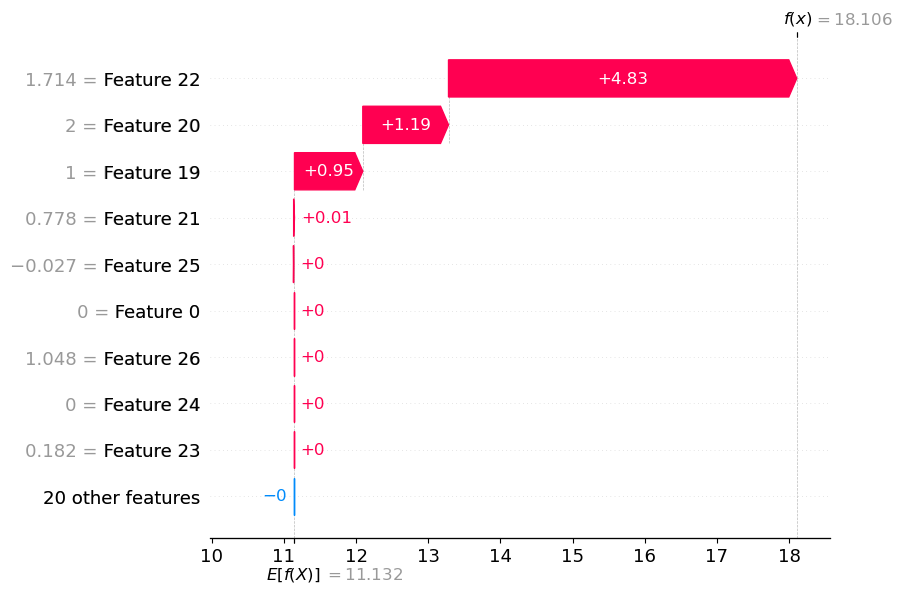

In [190]:
shap.plots.waterfall(shap_values[400])

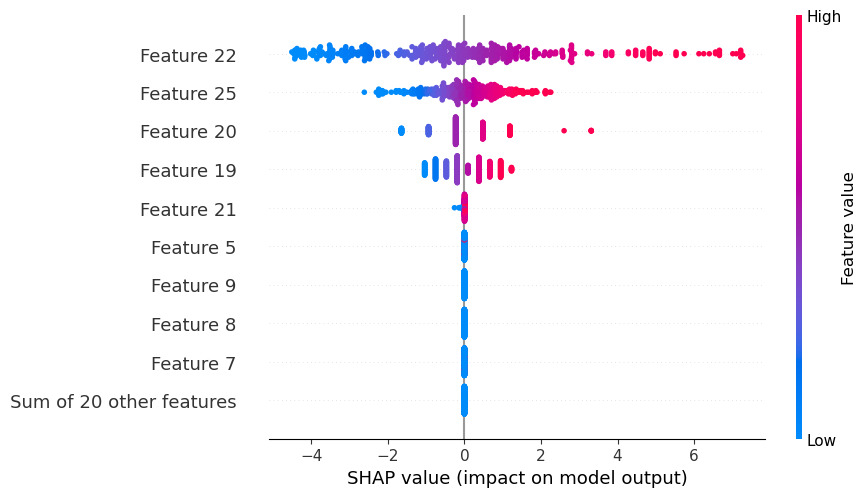

In [191]:
shap.plots.beeswarm(shap_values)

`Feature 22 = dmc`
`Feature 25 = temp`
`Feature 20 = coord_y`
`Feature 19 = coord_x`
`Feature 21 = ffmc`

*(Answer here.)*

>In general the Lasso model's most important feature was `'dmc'` and outside of dmc, temp, and xy coords the rest of the features were unimportant

>To improve model performance I would try other models than Lasso. The Lasso model missed the role of relative humidity `rh` and the categorical vairables like `month` and `day`. 

>The way to test whether features are actually enhancing model performance could be to experiment with various pipelines and models first while keeping track of experiment results in `Sacred`. The `SHAP` anlysis took 12min to compute so it would be efficient to only analyze the importance features of the best models to decide whether to validate or invalidate the hypothesis of relevance of a given feature.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.